# GLM: Gamma, Lognormal and Weibull

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


# 0. Generation of Data:

## 0.1. From Weibull:


In [2]:
nsim = 10000
ntrain = np.int_(nsim/2)
x1_candidate = np.array([0,1.0])
x1 = np.random.choice(x1_candidate, nsim)
x2 = np.random.uniform(0,1,nsim)
alpha_=np.array([0.4, -0.2, 0.35])
lambda_ = np.exp(alpha_[0] + alpha_[1]*x1 + alpha_[2]*x2) # scale
sig_ =1.7 #shape
y = np.random.weibull(sig_, size=nsim) * lambda_
ones = np.ones(nsim)

## 0.2 From log-normal:

In [3]:
# nsim = 10000
# ntrain = np.int_(nsim/2)
# x1_candidate = np.array([0,1.0])
# x1 = np.random.choice(x1_candidate, nsim)
# x2 = np.random.uniform(0,1,nsim)
# alpha_=np.array([0.4, -0.2, 0.35])
# lambda_true = np.exp(alpha_[0] + alpha_[1]*x1 + alpha_[2]*x2) # scale
# sig_ =1.0 #shape
# y = torch.tensor(torch.exp(torch.tensor(lambda_true)+torch.randn(nsim)*sig_), dtype=torch.float32)
# ones = np.ones(nsim)

In [4]:
X = torch.tensor(np.stack([ones, x1, x2], axis=1), dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.float32)
print(X.shape, Y.shape)

torch.Size([10000, 3]) torch.Size([10000])


In [5]:
train_data = TensorDataset(X[:ntrain, ], Y[:ntrain, ].reshape([-1, 1]))
trainloader= DataLoader(dataset = train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(X[ntrain:, ], Y[ntrain:, ].reshape([-1, 1]))
testloader= DataLoader(dataset = test_data, batch_size=5000, shuffle=False)


## 1. Weibull distribution

In [6]:
def log_weib(x,n,a): # n:scale, a:shape
    return torch.log((a / n)) +  (a - 1)*torch.log(x / n) -(x / n)**a

In [7]:
a1 = torch.tensor(torch.rand(1), requires_grad=True)
DN1 = torch.nn.Sequential(
    torch.nn.Linear(3, 1, bias=False),
)

def loss_ftn_wei(y, yhat):
  return -torch.sum(log_weib(y, yhat, a1))
optimizer = torch.optim.SGD(list(DN1.parameters())+[a1], lr=0.0001)
history = []

<ipython-input-7-8516a136dce6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a1 = torch.tensor(torch.rand(1), requires_grad=True)


In [8]:
epochs=100
history=[]

for epoch in range(epochs):
  running_loss =0
  for xx, yy in trainloader:
    optimizer.zero_grad()
    uhat1 = torch.exp(DN1(xx))
    loss = loss_ftn(yy, uhat1)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  history.append(running_loss/len(trainloader.dataset))

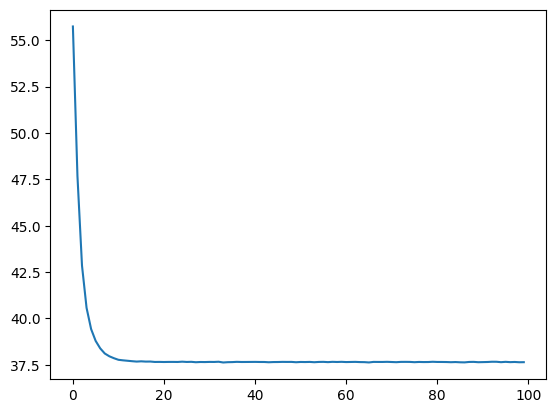

In [9]:
plt.plot(history)

In [ ]:
mse1=0
for xx, yy in testloader:
  yhat1 = torch.exp(DN1(xx)) * torch.exp(torch.lgamma(1+1/a1))
  mse1 +=torch.sum((yy-yhat1)**2)

mse1/len(testloader.dataset)

tensor(0.7864, grad_fn=<DivBackward0>)

## Lognorm distribution

In [ ]:
def log_pdf_normal(x, u, s):
    return -torch.log(x*s*torch.sqrt(torch.tensor(2.0)*torch.pi)) -  ( torch.log(x)-u )**2/2/s**2

In [ ]:
a2 = torch.tensor(torch.rand(1), requires_grad=True)
DN2 = torch.nn.Sequential(
    torch.nn.Linear(3, 1, bias=False),
)

def loss_ftn(y, yhat):
  return -torch.sum(log_pdf_normal(y, yhat, a2))
optimizer = torch.optim.SGD(list(DN2.parameters())+[a2], lr=0.001)
history = []

<ipython-input-375-44de14f550ab>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a2 = torch.tensor(torch.rand(1), requires_grad=True)


In [ ]:
epochs=200
history=[]

for epoch in range(epochs):
  running_loss =0
  for xx, yy in trainloader:
    optimizer.zero_grad()
    uhat2 = torch.exp(DN2(xx))
    loss = loss_ftn(yy, uhat2)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  history.append(running_loss/len(trainloader.dataset))

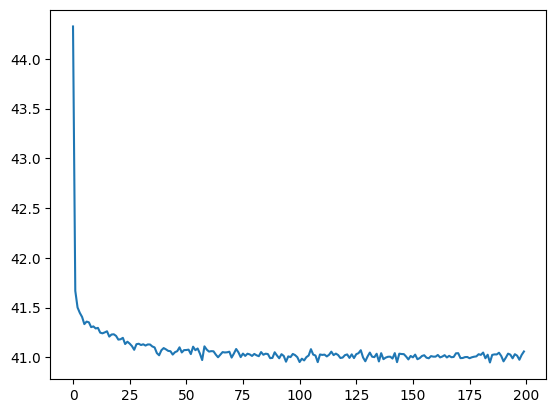

In [ ]:
plt.plot(history)

In [ ]:
DN2[0].weight

Parameter containing:
tensor([[-2.5715, -0.9893,  1.9182]], requires_grad=True)

In [ ]:
a2

tensor([0.7482], requires_grad=True)

In [ ]:
alpha_

array([ 0.4 , -0.2 ,  0.35])

In [ ]:
mse2=0
for xx, yy in testloader:
  #torch.mean((yhat_True-yhat1)**2)
  yhat2 = torch.exp(torch.exp(DN2(xx))+a2**2/2)
  mse2 +=torch.sum((yy-yhat2)**2)

mse2/len(testloader.dataset)

tensor(0.8049, grad_fn=<DivBackward0>)

In [ ]:
#torch.mean((yhat_True-yhat2)**2)

In [ ]:
torch.mean((yhat1-yhat2)**2)

tensor(0.0187, grad_fn=<MeanBackward0>)

In [ ]:
a2

tensor([0.7482], requires_grad=True)

## 2. Comparison of the prediction of $E[Y \wedge d]$

In [ ]:
# When True model is Log normal
q = torch.tensor([0.1, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ds = torch.quantile(Y, q)

MSE_btw_1_2 = torch.ones([8])
myMSE1 = torch.ones([8])
myMSE2 = torch.ones([8])
for i in range(8):
 d = ds[i]
 for xx, yy in testloader:
  #lambda_true_test = torch.exp(xx@torch.tensor([[0.4, -0.2, 0.35]]).T)
  #yhat_True = torch.exp(lambda_true_test + sig_**2/2)
  lambda_1 = torch.exp(DN1(xx))
  my_gamma = torch.exp(torch.lgamma(1+1/a1))
  my_gamma_inc = torch.special.gammainc(1+1/a1, (d/lambda_1)**a1)
  # E[Y ^ d]
  Ey_small_d_mod1 = lambda_1 * my_gamma *my_gamma_inc + d*torch.exp(-(d/lambda_1)**a1)
  # E[(Y-d)_+]
  Ey_minus_d_mod1 = yhat1- Ey_small_d_mod1

 m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
 for xx, yy in testloader:
  uhat2 = torch.exp(DN2(xx))
  # E[Y ^ d]
  #Ey_small_d_True = torch.exp(lambda_true_test+sig_**2/2)*m.cdf((torch.log(d)-lambda_true_test-sig_**2)/sig_)+d*(1-m.cdf((torch.log(d)-lambda_true_test)/sig_))
  Ey_small_d_mod2 = torch.exp(uhat2+a2**2/2)*m.cdf((torch.log(d)-uhat2-a2**2)/a2)+d*(1-m.cdf((torch.log(d)-uhat2)/a2))
  # E[(Y-d)_+]
  Ey_minus_d_mod2 = yhat2 - Ey_small_d_mod2
 #myMSE1[i] = torch.mean((Ey_small_d_True-Ey_small_d_mod1)**2)
 #myMSE2[i] = torch.mean((Ey_small_d_True-Ey_small_d_mod2)**2)
 MSE_btw_1_2[i] = torch.mean((Ey_small_d_mod2-Ey_small_d_mod1)**2)


In [ ]:
MSE_btw_1_2

tensor([3.5338e-05, 4.9495e-05, 4.6190e-04, 1.2569e-03, 2.4797e-03, 3.8761e-03,
        5.2721e-03, 6.0631e-03], grad_fn=<CopySlices>)

In [ ]:
torch.mean((yy - yhat1 )**2)

tensor(0.7864, grad_fn=<MeanBackward0>)

In [ ]:
torch.mean((yhat1 - yhat2 )**2)

tensor(0.0187, grad_fn=<MeanBackward0>)

In [ ]:
torch.mean((yy - yhat2 )**2)

tensor(0.8049, grad_fn=<MeanBackward0>)

In [ ]:
torch.mean(yy)

tensor(2.0986)

In [ ]:
torch.std(yy)

tensor(3.1497)

# HW Problem 3: Gamma regression

Using the same data as in the previous examples, you want to use the following Gamma regression model.

$
y_i \sim Gamma(mean = \mu_i, dispersion = \psi)
$
where $\mu_i = \exp(X_i \beta)$.

Answer the following questions.

1. Derive the MLE estimators of $\beta$ and $\psi$, and calculate AIC. Compare the AICs of Gamma regression and Weibull regression. Which is better?

2. Calculate Test MSE and compare the result with Weibull regression. Which is better?



In [10]:
def log_pdf_gamma(x, alp, bet):
    m = torch.distributions.gamma.Gamma(alp,bet)
    return m.log_prob(x)

In [11]:
disp = torch.tensor(torch.rand(1), requires_grad=True)
DN_gamma = torch.nn.Sequential(
    torch.nn.Linear(3, 1, bias=False),
)

def loss_ftn(y, yhat):
  return -torch.sum(log_pdf_gamma(y, 1.0/disp, 1.0/disp/yhat))
optimizer = torch.optim.SGD(list(DN_gamma.parameters())+[disp], lr=0.001)
history = []

<ipython-input-11-f245fd03074a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  disp = torch.tensor(torch.rand(1), requires_grad=True)


In [12]:
epochs=200
history=[]

for epoch in range(epochs):
  running_loss =0
  for xx, yy in trainloader:
    optimizer.zero_grad()
    yhat = torch.exp(DN_gamma(xx))
    loss = loss_ftn(yy, yhat)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
  history.append(running_loss/len(trainloader.dataset))

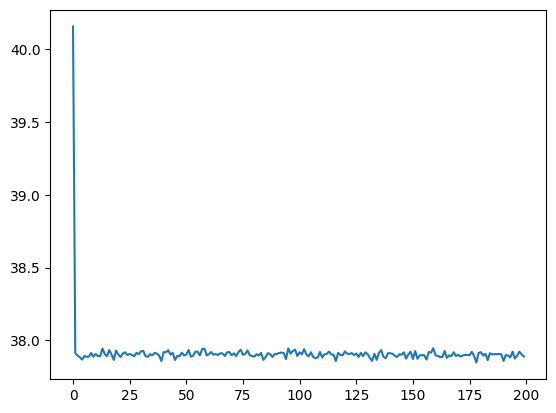

In [13]:
plt.plot(history)

#### 1. Derive the MLE estimators of $\beta$ and $\psi$, and calculate AIC. Compare the AICs of Gamma regression and Weibull regression. Which is better?


In [16]:
print(f'Weibull betas : {DN1[0].weight} and \n shape : {a1}')
print(f'Gamma betas : {list(DN_gamma[0].weight)} and \n dispersion : {disp}')

Weibull betas : Parameter containing:
tensor([[ 0.4049, -0.2174,  0.3550]], requires_grad=True) and 
 shape : tensor([1.7072], requires_grad=True)
Gamma betas : [tensor([ 0.2906, -0.1912,  0.3641], grad_fn=<UnbindBackward0>)] and 
 dispersion : tensor([0.3781], requires_grad=True)


In [38]:
torch.exp(DN1(X)).shape

torch.Size([10000, 1])

In [20]:
Y.shape

torch.Size([10000])

In [22]:
# AIC
def loss_ftn_wei(y, yhat):
  return -torch.sum(log_weib(y, yhat, a1))

def loss_ftn_gamm(y, yhat):
  return -torch.sum(log_pdf_gamma(y, 1.0/disp, 1.0/disp/yhat))

Wei_Yhat = torch.exp(DN1(X)) * torch.exp(torch.lgamma(1+1/a1))
Gam_Yhat = torch.exp(DN_gamma(X))
AIC_wei = -2* (-loss_ftn_wei(Y.reshape(-1,1), Wei_Yhat)) + 2 *4
AIC_gamm = -2* (-loss_ftn_gamm(Y.reshape(-1,1), Gam_Yhat)) + 2 *4

print(f'AIC of Weibull:{AIC_wei}')
print(f'AIC of Gamma:{AIC_gamm}')

AIC of Weibull:23986.42578125
AIC of Gamma:23790.125


#### 2. Calculate Test MSE and compare the result with Weibull regression. Which is better?

#### MSE

In [23]:
mse_wei=0
for xx, yy in testloader:
  #yhat_True = torch.exp(torch.exp(xx@torch.tensor([[0.4, -0.2, 0.35]]).T) + sig_**2/2)
  yhat_wei = torch.exp(DN1(xx)) * torch.exp(torch.lgamma(1+1/a1))
  mse_wei +=torch.sum((yy-yhat_wei)**2)

mse_wei/len(testloader.dataset)

tensor(0.7954, grad_fn=<DivBackward0>)

In [24]:
mse_gam=0
for xx, yy in testloader:
  yhat_gam = torch.exp(DN_gamma(xx))
  mse_gam +=torch.sum((yy-yhat_gam)**2)

mse_gam/len(testloader.dataset)

tensor(0.7961, grad_fn=<DivBackward0>)

근소하게 weibull distribution으로 가정한 결과가 더 좋아보임.

In [25]:
print(f'MSE of Weibull: {mse_wei/len(testloader.dataset)}\nMSE of Gamma: {mse_gam/len(testloader.dataset)}')

MSE of Weibull: 0.7953805327415466
MSE of Gamma: 0.7960628867149353
